# Training an Attention Model on Tensorflow Datasets
## Prerequisites

In [1]:
import json
import os
from typing import Any, Callable, Tuple

import numpy as np
import pandas as pd
import tensorflow as tf
import tensorflow_datasets as tfds
from IPython.core.display import display
from mmproteo.utils import log, paths, utils, visualization
from mmproteo.utils.formats.tf_dataset import DatasetLoader
from mmproteo.utils.ml import callbacks, evaluation
from official.modeling import tf_utils
from official.nlp.modeling.models.seq2seq_transformer import Seq2SeqTransformer, TransformerDecoder, TransformerEncoder
from official.nlp.modeling.ops import beam_search

In [2]:
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', 1000)

In [3]:
os.environ["CUDA_VISIBLE_DEVICES"]="7"

In [4]:
#tf.debugging.set_log_device_placement(True)
GPUs = tf.config.list_physical_devices('GPU')
GPUs

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

## Configuration

In [5]:
!pwd

/hpi/fs00/home/mirko.krause/masterthesis/pride-downloader/notebooks


In [6]:
if os.getcwd() == "/tf":
    os.chdir(os.path.join('workspace', 'notebooks'))

In [7]:
!pwd

/hpi/fs00/home/mirko.krause/masterthesis/pride-downloader/notebooks


In [8]:
PROJECT = "PXD010000"

In [9]:
DUMP_PATH = os.path.join("/scratch/mirko.krause/dumps/", PROJECT)

In [10]:
print(f"dump path = {DUMP_PATH}")
THREAD_COUNT = min(int(os.cpu_count()/2), 16)
TRAINING_COLUMNS_DUMP_PATH = os.path.join(DUMP_PATH, "training_columns")
FILES_PATH = os.path.join(TRAINING_COLUMNS_DUMP_PATH, "*_mzmlid.parquet")
STATISTICS_FILE_PATH = os.path.join(TRAINING_COLUMNS_DUMP_PATH, "statistics.parquet")
DATASET_DUMP_PATH = os.path.join(TRAINING_COLUMNS_DUMP_PATH, "tf_datasets")
PROCESSING_FILE_PATH = os.path.join(DATASET_DUMP_PATH, "processing_info.json")

dump path = /scratch/mirko.krause/dumps/PXD010000


In [11]:
SEQ = 'peptide_sequence'

In [12]:
logger = log.create_logger(
    name='mmproteo_attention_model',
    verbose=True,
    log_dir=DUMP_PATH,
)

2021-07-16 16:16:52,977 - mmproteo_attention_model: Logging to file '/scratch/mirko.krause/dumps/PXD010000/mmproteo_attention_model.log' and to stderr


In [13]:
with open(PROCESSING_FILE_PATH, 'r') as file:
    PROCESSING_INFO = json.loads(file.read())
PROCESSING_INFO

{'padding_characters': {'peptide_sequence': '_',
  'mz_array': 0.0,
  'intensity_array': 0.0},
 'padding_lengths': {'mz_array': 2354,
  'intensity_array': 2354,
  'peptide_sequence': 50},
 'idx_to_char': {'0': 'A',
  '1': 'C',
  '2': 'D',
  '3': 'E',
  '4': 'F',
  '5': 'G',
  '6': 'H',
  '7': 'I',
  '8': 'K',
  '9': 'L',
  '10': 'M',
  '11': 'M(Oxidation)',
  '12': 'N',
  '13': 'P',
  '14': 'Q',
  '15': 'R',
  '16': 'S',
  '17': 'T',
  '18': 'V',
  '19': 'W',
  '20': 'Y',
  '21': '_'},
 'normalization': {'intensity_array': '<function base_peak_normalize at 0x7f8e5c0cf550>'},
 'split_value_columns': ['species', 'istrain'],
 'training_data_columns': ['mz_array', 'intensity_array'],
 'target_data_columns': ['peptide_sequence']}

In [14]:
idx_to_char = {int(idx): char for idx, char in PROCESSING_INFO["idx_to_char"].items()}
idx_to_char[-1] = "[start]"
char_to_idx = {char: idx for idx, char in idx_to_char.items()}

## Loading Tensorflow Datasets

In [15]:
KEEP_CACHE = True

In [16]:
BATCH_SIZE = 8

In [17]:
TRAINING_TYPE = 'Train'
TEST_TYPE = 'Test'
EVAL_TYPE = 'Eval'

In [18]:
dataset_file_paths = paths.assign_wildcard_paths_to_splits_grouped_by_path_position_value(
    wildcard_path=os.path.join(
        DATASET_DUMP_PATH,
        '*',  # filename
        '*',  # species
        '*'  # istrain
    ),
    path_position=-2,
    splits={
        TRAINING_TYPE: 0.4,
        TEST_TYPE: 0.5,
        EVAL_TYPE: 0.6
    },
    paths_dump_file=os.path.join(
        DATASET_DUMP_PATH,
        "dataset_file_paths.json"
    ),
    skip_existing=KEEP_CACHE,
    logger=logger
)

print()
print("assigned dataset files:")
visualization.print_list_length_in_dict(dataset_file_paths)


assigned dataset files:
#Train = 89
e.g.: /scratch/mirko.krause/dumps/PXD010000/training_columns/tf_datasets/Biodiversity_P_polymyxa_TBS_aerobic_1_17July16_Samwise_16-04-10_mzmlid.parquet/Paenibacillus_polymyxa_ATCC842/Train
#Test = 27
e.g.: /scratch/mirko.krause/dumps/PXD010000/training_columns/tf_datasets/Cj_media_MH_R3_23Feb15_Arwen_14-12-03_mzmlid.parquet/Campylobacter_jejuni/Train
#Eval = 38
e.g.: /scratch/mirko.krause/dumps/PXD010000/training_columns/tf_datasets/M_alcali_copp_CH4_B3_T1_11_QE_23Mar18_Oak_18-01-07_mzmlid.parquet/Methylomicrobium_alcaliphilum/Train


2021-07-16 16:16:52,995 - mmproteo_attention_model: found file paths dump '/scratch/mirko.krause/dumps/PXD010000/training_columns/tf_datasets/dataset_file_paths.json'


### Loading corresponding TF datasets

In [19]:
element_spec = (
    tuple(tf.TensorSpec(shape=(PROCESSING_INFO['padding_lengths'][col],), dtype=tf.float32, name=col)
          for col in PROCESSING_INFO['training_data_columns']),
    tuple(tf.TensorSpec(shape=(PROCESSING_INFO['padding_lengths'][col],), dtype=tf.int8, name=col)
          for col in PROCESSING_INFO['target_data_columns'])
)
element_spec

((TensorSpec(shape=(2354,), dtype=tf.float32, name='mz_array'),
  TensorSpec(shape=(2354,), dtype=tf.float32, name='intensity_array')),
 (TensorSpec(shape=(50,), dtype=tf.int8, name='peptide_sequence'),))

**In the following step, Tensorflow starts allocating a GPU**

In [20]:
# initialize Tensorflow (might take several minutes (~5))
tf.data.Dataset.range(5)

<RangeDataset shapes: (), types: tf.int64>

In [21]:
ds_options = tf.data.Options()
ds_options.experimental_threading.private_threadpool_size = THREAD_COUNT
ds_options.experimental_threading.max_intra_op_parallelism = THREAD_COUNT

In [22]:
datasets = DatasetLoader(
    element_spec=element_spec,
    batch_size=BATCH_SIZE,
    shuffle_buffer_size=100_000,
    thread_count=min(int(os.cpu_count()/4), 4),
    keep_cache=KEEP_CACHE,
    logger=logger,
    run_benchmarks=False,
    options=ds_options,
).load_datasets_by_type(dataset_file_paths)
datasets

2021-07-16 16:23:02,917 - mmproteo_attention_model: DEBUG: preparing dataset 'Train' with 89 paths
2021-07-16 16:23:02,919 - mmproteo_attention_model: DEBUG: applied options to dataset 'Train'
2021-07-16 16:23:02,975 - mmproteo_attention_model: DEBUG: loaded dataset 'Train' interleaved
2021-07-16 16:23:02,976 - mmproteo_attention_model: DEBUG: shuffled dataset 'Train'
2021-07-16 16:23:02,977 - mmproteo_attention_model: DEBUG: batched dataset 'Train'
2021-07-16 16:23:02,977 - mmproteo_attention_model: DEBUG: skipped caching dataset 'Train'
2021-07-16 16:23:02,977 - mmproteo_attention_model: DEBUG: configured prefetching for dataset 'Train'
2021-07-16 16:23:02,977 - mmproteo_attention_model: DEBUG: skipped benchmarking dataset 'Train'
2021-07-16 16:23:02,978 - mmproteo_attention_model: prepared dataset 'Train'
2021-07-16 16:23:02,978 - mmproteo_attention_model: DEBUG: preparing dataset 'Test' with 27 paths
2021-07-16 16:23:02,978 - mmproteo_attention_model: DEBUG: applied options to data

{'Train': <PrefetchDataset shapes: (((8, 2354), (8, 2354)), ((8, 50),)), types: ((tf.float32, tf.float32), (tf.int8,))>,
 'Test': <PrefetchDataset shapes: (((8, 2354), (8, 2354)), ((8, 50),)), types: ((tf.float32, tf.float32), (tf.int8,))>,
 'Eval': <PrefetchDataset shapes: (((8, 2354), (8, 2354)), ((8, 50),)), types: ((tf.float32, tf.float32), (tf.int8,))>}

In [23]:
original_datasets = datasets

In [24]:
def prefix_target_sequences_with_start_token(tensor: tf.Tensor, token: Any = char_to_idx["[start]"]) -> tf.Tensor:
    return tf.concat(
        values=[
            tf.broadcast_to(
                input=tf.constant(token, dtype=tensor.dtype),
                shape=(
                    tensor.shape[0],  # batch dimension
                    1
                )
            ),
            tensor
        ],
        axis=1
    )


def _dataset_mapper_for_transformer(trainings: Tuple[tf.Tensor], targets: Tuple[tf.Tensor]):
    inputs = tf.stack(trainings, axis=-1)[:, :500, :]  # cut off too long spectra
    targets = prefix_target_sequences_with_start_token(targets[0])
    targets = tf.cast(
        x=targets,
        dtype=tf.int32,
    )

    return (
        {
            "inputs": inputs,
            "targets": targets[:, :-1],
        },
        targets[:, 1:]
    )


def prepare_dataset_for_transformer_training(dataset: tf.data.Dataset) -> tf.data.Dataset:
    return dataset.map(_dataset_mapper_for_transformer)

In [25]:
datasets = {
    t: prepare_dataset_for_transformer_training(dataset) for t, dataset in original_datasets.items()
}
datasets

{'Train': <MapDataset shapes: ({inputs: (8, 500, 2), targets: (8, 50)}, (8, 50)), types: ({inputs: tf.float32, targets: tf.int32}, tf.int32)>,
 'Test': <MapDataset shapes: ({inputs: (8, 500, 2), targets: (8, 50)}, (8, 50)), types: ({inputs: tf.float32, targets: tf.int32}, tf.int32)>,
 'Eval': <MapDataset shapes: ({inputs: (8, 500, 2), targets: (8, 50)}, (8, 50)), types: ({inputs: tf.float32, targets: tf.int32}, tf.int32)>}

In [26]:
print("original datasets:")
display(tfds.benchmark(original_datasets[TEST_TYPE]))

print()

print("mapped datasets:")
display(tfds.benchmark(datasets[TEST_TYPE]))

original datasets:


1it [00:00, ?it/s]


************ Summary ************

Examples/sec (First included) 5003.16 ex/sec (total: 74217 ex, 14.83 sec)
Examples/sec (First only) 0.46 ex/sec (total: 1 ex, 2.17 sec)
Examples/sec (First excluded) 5859.83 ex/sec (total: 74216 ex, 12.67 sec)


,duration,num_examples,avg
first+lasts,14.834022,74217,5003.160902
first,2.168818,1,0.461081
lasts,12.665204,74216,5859.834339



mapped datasets:


1it [00:00, ?it/s]


************ Summary ************

Examples/sec (First included) 3625.52 ex/sec (total: 74217 ex, 20.47 sec)
Examples/sec (First only) 0.47 ex/sec (total: 1 ex, 2.12 sec)
Examples/sec (First excluded) 4044.84 ex/sec (total: 74216 ex, 18.35 sec)


,duration,num_examples,avg
first+lasts,20.470716,74217,3625.520561
first,2.122401,1,0.471164
lasts,18.348314,74216,4044.840237


## Building the Tensorflow Model

In [27]:
# heavily based on:
# https://github.com/tensorflow/models/blob/061c58a3937953c79819fd4e8826af1570cb6024/official/nlp/transformer/transformer.py
# (29.06.2021)
class MyTransformer(Seq2SeqTransformer):
    def call(self, inputs):
        """Calculate target logits or inferred target sequences.
        Args:
          inputs: a dictionary of tensors.
            Feature `inputs`: int tensor with shape `[batch_size, input_length]`.
            Feature `targets` (optional): None or int tensor with shape
              `[batch_size, target_length]`.
        Returns:
          If targets is defined, then return logits for each word in the target
          sequence, which is a float tensor with shape
          `(batch_size, target_length, vocab_size)`. If target is `None`, then
          generate output sequence one token at a time and
          returns a dictionary {
              outputs: `(batch_size, decoded_length)`
              scores: `(batch_size, 1)`}
          Even when `float16` is used, the output tensor(s) are always `float32`.
        Raises:
          NotImplementedError: If try to use padded decode method on CPU/GPUs.
        """
        sources = inputs["inputs"]
        targets = inputs.get("targets", None)
        # Prepare inputs to the layer stack by adding positional encodings and
        # applying dropout.

        sources = self.source_embedding(sources)
        # Attention_mask generation.
        input_shape = tf_utils.get_shape_list(sources, expected_rank=3)
        batch_size = input_shape[0]
        input_length = input_shape[1]
        channel_count = input_shape[2]
        non_padding_sources = tf.not_equal(sources[:, :, 0], 0.0)
        non_padding_sources = tf.reshape(
            tensor=non_padding_sources,
            shape=[batch_size, 1, input_length]
        )
        attention_mask = tf.cast(
            x=non_padding_sources,
            dtype=sources.dtype
        )
        broadcast_ones = tf.ones(
            shape=[batch_size, input_length, 1],
            dtype=sources.dtype
        )
        attention_mask = broadcast_ones * attention_mask

        pos_encoding = self.position_embedding(sources)
        pos_encoding = tf.cast(pos_encoding, sources.dtype)
        encoder_inputs = sources + pos_encoding

        encoder_inputs = self.encoder_dropout(encoder_inputs)

        encoder_outputs = self.encoder_layer(
            encoder_inputs, attention_mask=attention_mask)

        if targets is None:
            if self._padded_decode:
                max_decode_length = self._decode_max_length
            else:
                max_decode_length = self._decode_max_length or (
                        tf.shape(encoder_outputs)[1] + self._extra_decode_length)
            symbols_to_logits_fn = self._get_symbols_to_logits_fn(max_decode_length)

            batch_size = tf.shape(encoder_outputs)[0]
            # Create initial set of IDs that will be passed to symbols_to_logits_fn.
            initial_ids = tf.zeros([batch_size], dtype=tf.int32)

            # Create cache storing decoder attention values for each layer.
            init_decode_length = (max_decode_length if self._padded_decode else 0)
            num_heads = self.decoder_layer.num_attention_heads
            dim_per_head = self._embedding_width // num_heads

            # Cache dtype needs to match beam_search dtype.
            # pylint: disable=g-complex-comprehension
            cache = {
                str(layer): {
                    "key":
                        tf.zeros(
                            [batch_size, init_decode_length, num_heads, dim_per_head],
                            dtype=self.compute_dtype),
                    "value":
                        tf.zeros(
                            [batch_size, init_decode_length, num_heads, dim_per_head],
                            dtype=self.compute_dtype)
                } for layer in range(self.decoder_layer.num_layers)
            }
            # pylint: enable=g-complex-comprehension

            # Add encoder output and attention bias to the cache.
            encoder_outputs = tf.cast(encoder_outputs, dtype=self.compute_dtype)
            attention_mask = tf.cast(
                tf.reshape(
                    tf.not_equal(sources, 0), [input_shape[0], 1, input_shape[1]]),
                dtype=self.compute_dtype)
            cache["encoder_outputs"] = encoder_outputs
            cache["encoder_decoder_attention_mask"] = attention_mask

            # Use beam search to find the top beam_size sequences and scores.
            decoded_ids, scores = beam_search.sequence_beam_search(
                symbols_to_logits_fn=symbols_to_logits_fn,
                initial_ids=initial_ids,
                initial_cache=cache,
                vocab_size=self._vocab_size,
                beam_size=self._beam_size,
                alpha=self._alpha,
                max_decode_length=max_decode_length,
                eos_id=self._eos_id,
                padded_decode=self._padded_decode,
                dtype=self.compute_dtype)

            # Get the top sequence for each batch element
            top_decoded_ids = decoded_ids[:, 0, 1:]
            top_scores = scores[:, 0]

            return {"outputs": top_decoded_ids, "scores": top_scores}

        decoder_inputs = self.embedding_lookup(targets)
        embedding_mask = tf.cast(tf.not_equal(targets, 0), decoder_inputs.dtype)
        decoder_inputs *= tf.expand_dims(embedding_mask, -1)
        # Shift targets to the right, and remove the last element
        decoder_inputs = tf.pad(decoder_inputs, [[0, 0], [1, 0], [0, 0]])[:, :-1, :]
        
        length = tf.shape(decoder_inputs)[1]
        pos_encoding = self.position_embedding(decoder_inputs)
        pos_encoding = tf.cast(pos_encoding, decoder_inputs.dtype)
        decoder_inputs += pos_encoding

        decoder_inputs = self.decoder_dropout(decoder_inputs)

        decoder_shape = tf_utils.get_shape_list(decoder_inputs, expected_rank=3)
        batch_size = decoder_shape[0]
        decoder_length = decoder_shape[1]

        self_attention_mask = tf.linalg.band_part(tf.ones([length, length]), -1, 0)
        self_attention_mask = tf.reshape(self_attention_mask, [1, length, length])
        self_attention_mask = tf.tile(self_attention_mask, [batch_size, 1, 1])

        attention_mask = tf.cast(
            tf.expand_dims(tf.not_equal(sources[:, :, 0], 0), axis=1), dtype=sources.dtype)
        attention_mask = tf.tile(attention_mask, [1, decoder_length, 1])

        outputs = self.decoder_layer(
            decoder_inputs,
            encoder_outputs,
            memory_mask=self_attention_mask,
            target_mask=attention_mask)
        
        logits = self._embedding_linear(self.embedding_lookup.embeddings, outputs)
        # Model outputs should be float32 to avoid numeric issues.
        # https://www.tensorflow.org/guide/mixed_precision#building_the_model
        logits = tf.cast(logits, tf.float32)
        return logits

In [98]:
TRANSFORMER_LAYERS = 8
ATTENTION_HEADS = 16
EMBEDDING_WIDTH = 512
LEARNING_RATE=10**-4

In [99]:
encoder_layer = TransformerEncoder(
    num_attention_heads=ATTENTION_HEADS,
    num_layers=TRANSFORMER_LAYERS,
)
decoder_layer = TransformerDecoder(
    num_attention_heads=ATTENTION_HEADS,
    num_layers=TRANSFORMER_LAYERS,
)

model = MyTransformer(
    vocab_size=len(idx_to_char),
    embedding_width=EMBEDDING_WIDTH,
    encoder_layer=encoder_layer,
    decoder_layer=decoder_layer,
    name=f"mmproteo_transformer_{utils.get_current_time_str()}",
    decode_max_length=PROCESSING_INFO['padding_lengths'][SEQ],
)
# create a new embedding layer that will be used in the overridden call method
model.source_embedding = tf.keras.layers.Conv1D(
    filters=EMBEDDING_WIDTH,
    kernel_size=1,
    activation=None,
    padding='same',
    name="source_embedding",
    use_bias=False,
)

model.compile(
    optimizer=tf.keras.optimizers.Adam(
        clipvalue=1.0,
        learning_rate=LEARNING_RATE,
    ),
    loss=tf.keras.losses.SparseCategoricalCrossentropy(),  #masked_loss,
    metrics=[
        tf.keras.metrics.SparseCategoricalAccuracy(),
        tf.keras.metrics.SparseCategoricalCrossentropy()
    ]
)

In [100]:
model.predict(datasets[EVAL_TYPE].unbatch().batch(1).take(1))

array([[[-1.2590714 , -0.17590019, -0.71137583, ..., -0.02930909,
          1.03345   ,  0.54510224],
        [-1.271511  , -0.11693441, -0.7379521 , ..., -0.01092649,
          1.0735459 ,  0.51591414],
        [-1.9694618 , -0.60591817, -0.7682354 , ...,  0.20859051,
          0.5662218 ,  0.33409524],
        ...,
        [-0.6415672 , -0.00874305, -1.3088547 , ..., -0.29422402,
          5.778578  ,  0.32821554],
        [-0.62884295,  0.01073998, -1.252422  , ..., -0.30767626,
          5.7521367 ,  0.3572952 ],
        [-0.6470138 ,  0.01884949, -1.1621841 , ..., -0.3433565 ,
          5.734303  ,  0.40780586]]], dtype=float32)

In [101]:
MODELS_PATH = os.path.join(DUMP_PATH, "models")
MODEL_PATH = os.path.join(MODELS_PATH, model.name)
MODEL_PATH

'/scratch/mirko.krause/dumps/PXD010000/models/mmproteo_transformer_20210717-174130'

In [102]:
utils.ensure_dir_exists(MODEL_PATH)

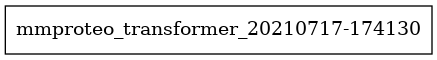

In [103]:
tf.keras.utils.plot_model(
    model=model,
    to_file=os.path.join(MODEL_PATH, "model.png"),
    show_shapes=True,
    expand_nested=True,
)

In [104]:
with open(os.path.join(MODEL_PATH, "summary.txt"), 'w') as file:
    def write_lines(line: str) -> None:
        file.write(line)
        file.write("\n")


    model.summary(print_fn=write_lines)
model.summary()

Model: "mmproteo_transformer_20210717-174130"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
on_device_embedding_3 (OnDev multiple                  11776     
_________________________________________________________________
transformer_encoder_3 (Trans multiple                  25203712  
_________________________________________________________________
transformer_decoder_3 (Trans multiple                  33600512  
_________________________________________________________________
relative_position_embedding_ multiple                  0         
_________________________________________________________________
dropout_6 (Dropout)          multiple                  0         
_________________________________________________________________
dropout_7 (Dropout)          multiple                  0         
_________________________________________________________________
source_embedding (Conv1D)    m

In [105]:
try:
    with open(os.path.join(MODEL_PATH, "model.json"), 'w') as file:
        file.write(model.to_json())

    with open(os.path.join(MODEL_PATH, "model.yaml"), 'w') as file:
        file.write(model.to_yaml())
except NotImplementedError as e:
    print("not implemented")

not implemented


## Training the Tensorflow Model

In [106]:
# Load the TensorBoard notebook extension
%load_ext tensorboard

The tensorboard extension is already loaded. To reload it, use:
  %reload_ext tensorboard


In [107]:
TENSORBOARD_LOG_DIR = os.path.join(MODEL_PATH, "tensorboard")
os.path.realpath(TENSORBOARD_LOG_DIR)

'/scratch/mirko.krause/dumps/PXD010000/models/mmproteo_transformer_20210717-174130/tensorboard'

In [108]:
training_dataset = datasets[TRAINING_TYPE].repeat()
validation_dataset = datasets[TEST_TYPE].repeat()

In [117]:
model.optimizer.get_config()

{'name': 'Adam',
 'clipvalue': 1.0,
 'learning_rate': 0.001,
 'decay': 0.0,
 'beta_1': 0.9,
 'beta_2': 0.999,
 'epsilon': 1e-07,
 'amsgrad': True}

In [116]:
model.optimizer.amsgrad = True

In [119]:
# to reset the learning_rate after it has been decreased by the reduce_lr callback
tf.keras.backend.set_value(model.optimizer.learning_rate, 10**-2)
model.optimizer.get_config()

{'name': 'Adam',
 'clipvalue': 1.0,
 'learning_rate': 0.01,
 'decay': 0.0,
 'beta_1': 0.9,
 'beta_2': 0.999,
 'epsilon': 1e-07,
 'amsgrad': True}

In [ ]:
model.fit(
    x=training_dataset,
    validation_data=validation_dataset,
    validation_steps=100,
    epochs=1000,
    steps_per_epoch=1000,
    callbacks=callbacks.create_callbacks(
        tensorboard=True,
        progressbar=False,
        reduce_lr=False,
        early_stopping=False,
        checkpoints=True,
        csv=False,
        base_path=MODEL_PATH,
    ),
    initial_epoch=0,
)

Epoch 1/1000
1000/1000 [==============================] - ETA: 0s - loss: 2.7763 - sparse_categorical_accuracy: 0.6280 - sparse_categorical_crossentropy: 2.7763

## Evaluating the Tensorflow Model

In [50]:
decode_idx: Callable[[np.ndarray], np.ndarray] = np.vectorize(idx_to_char.get)

In [51]:
evaluator = evaluation.SequenceEvaluator(
    dataset=datasets[EVAL_TYPE],
    decode_func=decode_idx,
    batch_size=BATCH_SIZE,
    separator=" ",
    padding_character=PROCESSING_INFO['padding_characters'][SEQ],
)

In [52]:
evaluator.evaluate_model(model)

5000/5000 [==============================] - 114s 22ms/step - loss: nan - sparse_categorical_accuracy: 0.6747 - sparse_categorical_crossentropy: nan


[nan, 0.6747210025787354, nan]

In [53]:
eval_df, (x_eval, y_eval, y_pred) = evaluator.evaluate_model_visually(
    model=model,
    sample_size=20,
    keep_separator=True,
)
eval_df

,predicted,true
0,G G V I V G V G G G G G G G G G _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _,A S E G G T G E G S I S T A E W A P A V D I K E E T D K F V L H
1,V V S V S S G S S K _ _ _ _ _ _ _ _ _ _ _ _ _ _ _,E I P G V F S Q G E T L E E L E E N I E D A Y K
2,V V S S A S S K S S S S S S S S S S S S S S S S,Q G F V T E L E T D T F P P G L D E E V I H K
3,V V V G G S S S S S S S S G S S S,A Y Y E P S H G S A P D I A G K
4,V V V G S S S G S G S G S S S _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _,M(Oxidation) N N N P P D E M N E E A A N T A V N A I F K E G L E N L K A L A E K
5,V V S V S S S S S K,E I E K H L E E K
6,V V V S G S S S S S S S,T E S P D L G W V I R
7,V V A S S S S S S S S S S K,F I E R R H E L A E C Y R
8,V V S A S S S S S S S S S S S,P L V G D N G S G M H V H Q
9,V V V S S K S S S S K _ _ _ _ _ _ _,L G N L A D G F G N G A G A N P R


In [54]:
eval_df.predicted.map(print)
None

G G V I V G V G G G G G G G G G _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _
V V S V S S G S S K _ _ _ _ _ _ _ _ _ _ _ _ _ _ _
V V S S A S S K S S S S S S S S S S S S S S S S
V V V G G S S S S S S S S G S S S
V V V G S S S G S G S G S S S _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _
V V S V S S S S S K
V V V S G S S S S S S S
V V A S S S S S S S S S S K
V V S A S S S S S S S S S S S
V V V S S K S S S S K _ _ _ _ _ _ _
V V A V S S S S S S S S
V V L S S S S S S S _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _
V V S A S S S S S
V V A A S S S S S S S S S S S S S S _ _ _ S S
V V S A A S S S S S S S S S S S S S
V V A S G S S S S S S S S S S S S S _
V V S A S S S S S S S S S S S S G S S S _
V V K A A K S S S S S S S
V V V S S S S S S S S S S S
V V G S S G S S S


broken loss function?

In [ ]:
np.argmax(y_pred[0], axis=1)

In [ ]:
datasets[EVAL_TYPE].take(1)

In [ ]:
model.predict(datasets[EVAL_TYPE].unbatch().batch(1).take(1))

In [ ]:
y_pred.shape

In [ ]:
y_pred